In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
import numpy as np

# Dataset:

bajarlo de Kagle:

https://www.kaggle.com/ml-lab-itba/yolointroitbadataset

Descomprimirlo en alguna carpeta y luego asignarla a la variable reduced_dataset_folder

# Tenemos 5 clases

In [64]:
classes_names = {
    'n04487081': 'tranvia',
    'n02108089': 'boxer',
    'n02701002': 'ambulacia',
    'n02279972': 'mariposa',
    'n04008634': 'misil'
}

In [51]:
# reduced_dataset_folder = '/Users/julianganzabal/facultad/lab-ml/datasets/challenge_dataset' #en la mac
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset' #ubuntu con GPU

In [52]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [53]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [110]:
classes = list(annotations_dict_train.keys())
print(classes)

['n04487081', 'n02108089', 'n02701002', 'n02279972', 'n04008634']


# Armamos un generador para Train y otro para Val
https://keras.io/preprocessing/image/

In [73]:
from keras.preprocessing.image import ImageDataGenerator

In [74]:
np.array([375, 500])/4

array([ 93.75, 125.  ])

In [75]:
target_size=(90, 120) #Con la MAC
# target_size=(375, 500) #Con GPU:(375, 500)
batch_size = 8 #Con la MAC
# batch_size = 64 #Con GPU:(375, 500)

In [76]:
datagen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=False)

train_generator = datagen_train.flow_from_directory(
    classes = classes,
    directory=train_folder,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1250 images belonging to 5 classes.


In [77]:
datagen_val = ImageDataGenerator(rescale=1./255, horizontal_flip=False)
val_generator = datagen_val.flow_from_directory(
    classes = classes,
    directory=val_folder,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 250 images belonging to 5 classes.


In [65]:
idx_2_class = {v:k for k,v in train_generator.class_indices.items()}

# Graficamos un Batch
(Cada vez que lo corremos trae imagenes diferentes)

In [80]:
from matplotlib import pyplot as plt

Batch size, Height, Width, Depth: (8, 90, 120, 3)
Batch size, classes: (8, 5)

clase: mariposa


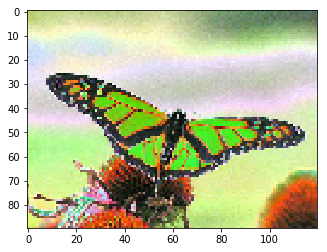

clase: tranvia


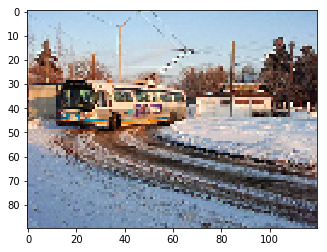

clase: mariposa


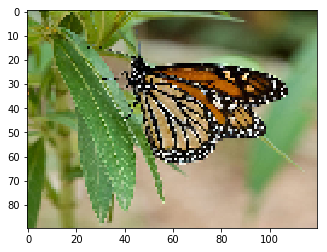

clase: tranvia


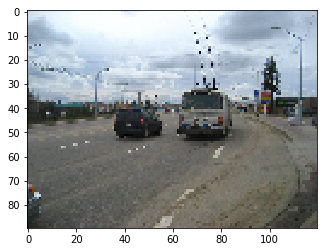

clase: misil


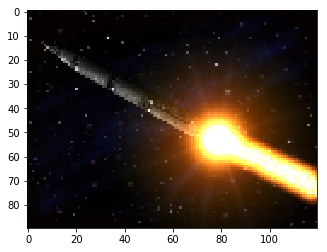

clase: tranvia


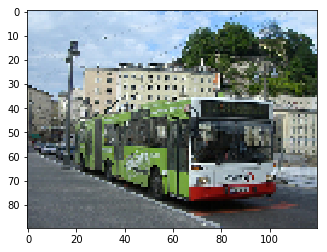

clase: ambulacia


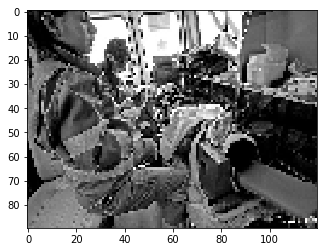

clase: boxer


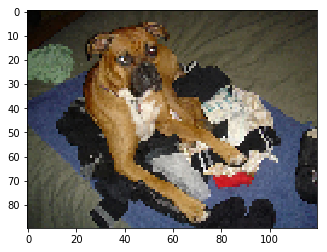

In [82]:
batch = next(val_generator)
print('Batch size, Height, Width, Depth:', batch[0].shape)
print('Batch size, classes:', batch[1].shape)
print()
for i, image in enumerate(batch[0]):
    plt.imshow(image)
    class_idx = np.argmax(batch[1][i])
    class_id = idx_2_class[class_idx]
    print('clase:', classes_names[class_id])
    plt.show()

# Armamos modelo usando tranfer learning con la VGG-16

In [83]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [84]:
n_classes = len(classes)

In [85]:
target_size

(90, 120)

In [86]:
N_trainable = 17
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=(*target_size, 3))
GAP = GlobalAveragePooling2D()(modelVGG16.output)
classification = Dense(n_classes, 
                           activation='softmax', 
                           name='category_output')(GAP)
model = Model(inputs=modelVGG16.input, outputs=classification)
print('Primer capa entrenable:', model.layers[N_trainable].name)
for layer in model.layers[N_trainable:]:
    layer.trainable = True
for layer in model.layers[:N_trainable]:
    layer.trainable = False

Primer capa entrenable: block5_conv3


In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 90, 120, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 120, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 120, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 30, 128)       0         
__________

In [88]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'classif_runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_acc', save_best_only=True)
model.compile(loss=["categorical_crossentropy"],
              optimizer=Adam(lr=0.001),
              metrics=["accuracy"])

In [89]:
from object_detection_helper import PlotLosses

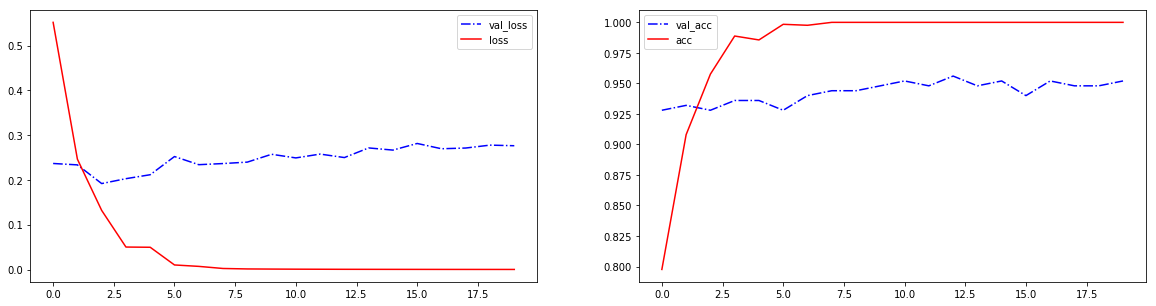

In [90]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=20,
        validation_data=val_generator, 
        callbacks = [plot_losses, checkpoint]
        )

# Evaluamos el modelo luego de entrenar por 20 epochs

In [92]:
loss, acc = model.evaluate_generator(train_generator)
print('Train loss:', loss)
print('Train Acc:', acc)

Train loss: 0.00013744464310368586
Train Acc: 1.0


In [93]:
loss, acc = model.evaluate_generator(val_generator)
print('Val loss:', loss)
print('Val Acc:', acc)

Val loss: 0.2765487001967522
Val Acc: 0.952


# Graficamos resultados

Imagenes mal clasificadas

clase: ambulacia


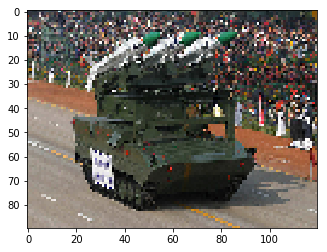

clase: misil


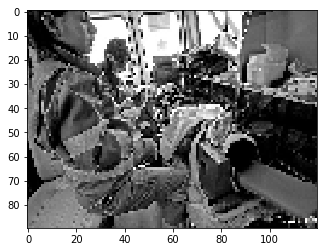

clase: boxer


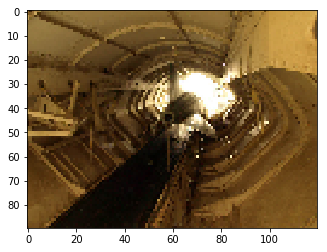

clase: tranvia


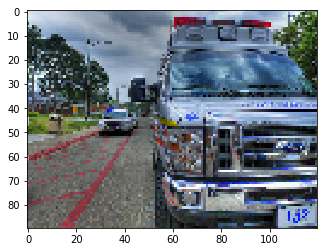

clase: boxer


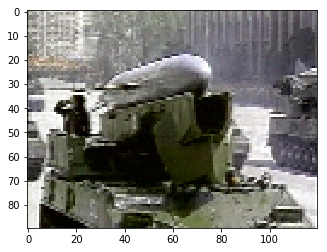

clase: tranvia


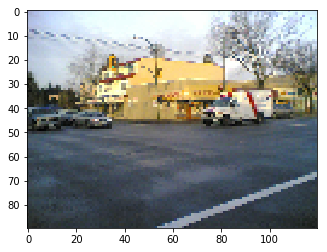

clase: boxer


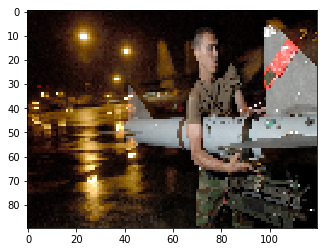

clase: misil


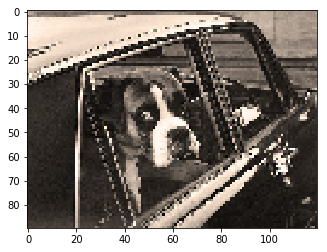

clase: misil


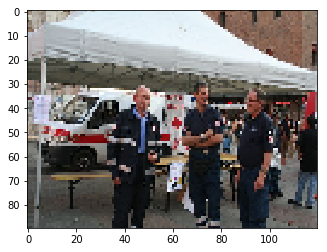

clase: boxer


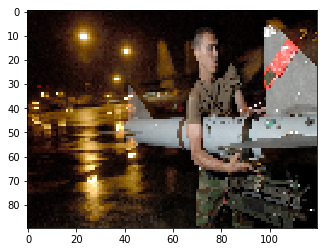

clase: boxer


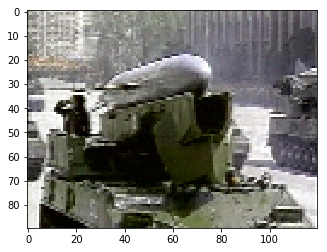

clase: tranvia


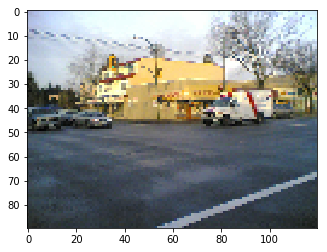

In [186]:
generator = val_generator
images_missed = []
for i in range(len(generator)):
    images, class_true = next(generator)
    class_pred = model.predict_on_batch(images)
    indexes = np.logical_not((np.argmax(class_pred, axis = 1) == np.argmax(class_true, axis=1)))
    for i, image in enumerate(images[indexes]):
        class_idx = np.argmax(class_pred, axis = 1)[indexes][i]
        class_id = idx_2_class[class_idx]
        print('clase:', classes_names[class_id])
        plt.imshow(image)
        plt.show()
        #print(indexes.sum())

# Modelo sin capas densas

## Supongamos una input shape

In [42]:
from keras.layers import Conv2D

In [40]:
input_shape=(375, 500,3)
N_trainable = 17
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#modelVGG16.summary()
output = modelVGG16.layers[-1].output
print(output)
last_w = output.shape[1].value
last_h = output.shape[2].value
print(last_w, last_h)
# Notar que el shape cambia al cambiar la entrada

Tensor("block5_pool_19/MaxPool:0", shape=(?, 11, 15, 512), dtype=float32)
11 15


In [45]:
dense_conv = Conv2D(filters = n_classes, kernel_size = (last_w, last_h), activation='softmax', name='category_output')
classification = dense_conv(modelVGG16.output)
model = Model(inputs=modelVGG16.input, outputs=classification)

In [49]:
print('Primer capa entrenable:', model.layers[N_trainable].name)
for layer in model.layers[N_trainable:]:
    layer.trainable = True
for layer in model.layers[:N_trainable]:
    layer.trainable = False

Primer capa entrenable: block5_conv3


In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 375, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 375, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 375, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 187, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 187, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 187, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 93, 125, 128)      0         
__________